## DeepTweets : Binary Classification task for tweets

### Outlines
- [1. Packages](#1)
- [2. Preprocessing](#2)
    - [2.1 Data importation](#2.1)
    - [2.2 Data Cleaning](#2.2)
- [3. RNN with Tensorflow](#3)
    - [3.1 Defining global variables](#3.1)
    - [3.2 Training - Validation Split](#3.2)
    - [3.3 Tokenization - Sequences, truncating and padding](#3.3)
    - [3.4 Using pre-defined Embeddings](#3.4)
    - [3.5 Representing the words in vocabulary using the embeddings](#3.5)
    - [3.6 Defining a model](#3.6)
    - [3.7 Plotting training history](#3.7)
    - [3.8 Testing model](#3.8)
- [4. Model comparison](#4)

<a name="1"></a>
### 1. Packages
- [numpy](https://numpy.org/) package for scientific computing.
- [pandas](https://pandas.pydata.org/ ) data analysis and manipulation library.
- [matplotlib](http://matplotlib.org) visualization library.
- [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) TensorFlow is an open source framework to run machine learning, deep learning and other statistical and predictive analytics workloads
- [scikitlearn](https://scikit-learn.org/stable/) machine learning library that supports supervised and unsupervised learning.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/) optimized distributed gradient boosting library.

In [240]:
import pandas as pd
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import linregress

<a name="2"></a>
### 2. Preprocessing

<a name="2.1"></a>
#### 2.1. Data importation
In the DeepTweet competition data from [kaggle](https://www.kaggle.com/competitions/deeptweets/data), we loaded The data into Pandas DataFrame objects. This DataFrame contain columns representing various attributes such as TweetId, Label and TweetText.
- **TweetId** : an anonymous id unique to a given tweet
- **Label** : the associated label which is either Sports or Politics
- **TweetText** : the text in a tweet

In [242]:
data = pd.read_csv('data/train.csv', delimiter=',', quotechar='"')
data

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,Politics,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,Sports,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either
6523,306088574221176832,Sports,'Which England player would you take out to di...


<a name="2.2"></a>
#### 2.2 Data Cleaning

In [243]:
def split_x_y(data):
    y = data['Label']
    X = data.drop(columns=['Label'])
    return X, y

X, y = split_x_y(data)

In [244]:
y = y.apply(lambda e : 0 if e == 'Sports' else 1)
y

0       1
1       1
2       0
3       0
4       0
       ..
6520    1
6521    0
6522    0
6523    0
6524    1
Name: Label, Length: 6525, dtype: int64

In [163]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    words = sentence.split()
    words_no_sw = [w for w in words if w not in stopwords]
    return " ".join(words_no_sw)

In [164]:
def remove_links(sentence):
    return re.sub(r"((https|http)?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", sentence)

In [246]:
def remove_tags(sentence, hatshtags):
    if hatshtags:
        return re.sub(r"(@|#)(\S+)", "", sentence)
    return re.sub(r"(@)(\S+)", "", sentence)

In [257]:
def delete_punc(sentence, hatshtags):
    punctuation = string.punctuation
    if not hatshtags :
        punctuation = punctuation.replace('#', '')
    return "".join([c for c in sentence if c not in punctuation])

In [255]:
def clean_data(X, hatshtags=False):
    # drop the id column
    sentences = X.drop(columns=['TweetId'])
    # removing english stopwords
    sentences['TweetText'] = sentences['TweetText'].apply(remove_stopwords)
    # removing links
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(remove_links)
    # removing tags
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(lambda s : remove_tags(s, hatshtags))
    # removing punctuation
    sentences.loc[:, 'TweetText'] = sentences['TweetText'].apply(lambda s : delete_punc(s, hatshtags))
    return sentences

In [258]:
sentences = clean_data(X)
sentences.head()

,TweetText
0,#seckerry value measured not dollars terms d...
1,fear so
2,watch video highlights #wwc13 final australia ...
3,rt nitro circus #albertpark #theymakeitlooks...
4,always good thing thanks feedback


<a name="3"></a>
### 3. RNN with Tensorflow

<a name="3.1"></a>
#### 3.1 Defining global variables

Next we will define some global variables that will be used throughout the first part.

- **EMBEDDING_DIM** : Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.
- **MAXLEN** : Maximum length of all sequences. Defaults to 64.
- **TRUNCATIN** : Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.
- **PADDING** : Padding strategy (pad either before or after each sequence.). Defaults to 'post'.
- **OOV_TOKEN** : Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to \"\<OOV>\".
- **TRAINING_SPLIT** : Proportion of data used for training. Defaults to 0.85

In [241]:
EMBEDDING_DIM = 100
MAXLEN = 64
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = 0.85

<a name="3.2"></a>
#### 3.2 Training - Validation Split

In [203]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, y, train_size=TRAINING_SPLIT, random_state=1)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 5546 sentences for training.

There are 5546 labels for training.

There are 979 sentences for validation.

There are 979 labels for validation.


<a name="3.3"></a>
#### 3.3 Tokenization - Sequences, truncating and padding

In [205]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [206]:
tokenizer = fit_tokenizer(train_sentences.TweetText, OOV_TOKEN)

vocab_size = len(tokenizer.word_index)

print(f"there are {vocab_size} in our vocabulary")

there are 11876 in our vocabulary


In [207]:
def seq_pad_trunc(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)

    return pad_trunc_sequences

In [208]:
train_pad_trunc_seq = seq_pad_trunc(train_sentences.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_trunc(val_sentences.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated train sequneces shape is : {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequneces shape is : {val_pad_trunc_seq.shape}\n")

Padded and truncated train sequneces shape is : (5546, 96)

Padded and truncated validation sequneces shape is : (979, 96)



In [209]:
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()

<a name="3.4"></a>
#### 3.4 Using pre-defined Embeddings
In our RNN model, we will use word embeddings. For this we will be using pre-trained word vectors.

In particular we will be using the 100 dimension version of [GloVe](https://nlp.stanford.edu/projects/glove/) from Stanford.

In [210]:
glove_file= './data/glove.twitter.27B.100d.txt'

GLOVE_EMBEDDINGS = {}
with open(glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [211]:
test_word = 'and'

test_word_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation shape is {test_word_vector.shape}\n")
print(f"Vector representation of the word \"{test_word}\" : \n{test_word_vector}")

Vector representation shape is (100,)

Vector representation of the word "and" : 
[-1.6697e-01 -3.2589e-01 -1.2003e-02 -1.3198e-01 -1.5361e-01  1.6556e-01
  2.5954e-01  1.3112e-01  1.0092e-02 -4.6486e-01 -2.1164e-01  6.4163e-02
 -6.4094e+00 -2.0224e-01 -8.3826e-03 -5.5104e-01  1.9716e-01 -3.7762e-01
 -5.0864e-01  6.3963e-02 -7.0967e-01  2.2478e-01 -9.5472e-02 -2.5516e-01
 -4.1501e-01 -1.9227e-01 -2.2220e-01  4.3598e-01  4.1871e-01 -1.4593e-03
 -4.6268e-01  1.5682e-01  7.0434e-02 -1.5911e-01 -3.9097e-02 -5.6209e-02
 -1.2356e-01  2.1481e-01  5.1988e-01 -8.1924e-02 -7.3352e-01 -2.7938e-01
 -1.3187e-01  5.8902e-01  4.0815e-01 -4.6319e-01 -2.7336e-02 -3.8121e-01
 -2.0352e-01 -5.2808e-01 -5.8097e-01 -7.5229e-01  9.4600e-02  1.4127e-01
  2.4297e-02 -3.9625e-02  2.2790e-01 -4.5293e-02  3.7604e-01  2.0081e-01
  4.9062e-02  2.0733e-01 -4.1955e-01  3.0427e-01  1.8665e-01  8.1929e-02
 -6.1025e-01 -2.3168e-01 -1.3766e-02  4.3951e-01  4.0073e-01 -2.9532e-01
  1.0936e-01 -9.4972e-02  2.2750e-01  1.97

<a name="3.5"></a>
#### 3.5 Representing the words in vocabulary using the embeddings

First, we save the vector representation of each word in the vocabulary in a numpy array.

- If a word in the vocabulary is not present in **GLOVE_EMBEDDINGS** the representation for that word is left as a column of zeros.
- **word_index** starts counting at 1, because of this you will need to add an extra column at the left-most side of the **EMBEDDINGS_MATRIX** array. This is the reason why we added 1 to **VOCAB_SIZE**.

In [212]:
EMBEDDING_MATRIX = np.zeros((vocab_size + 1, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[i] = embedding_vector

<a name="3.6"></a>
#### 3.6 Defining a model
Now we define a model that will handle our classification problem while not overfitting.

- The first layer is Embedding layer witch is configured by using pre-trained embeddings.
- Then we used different combinations of layers such as:
    - **LSTM**
    - **Bidirectional(LSTM)**
    - **BatchNormalization**
- The last two layers should be **Dense** layers.
- At last, we Icluded a **Dropout** layer to mitigate overfitting.

In [218]:
model = Sequential([
    Embedding(vocab_size + 1, EMBEDDING_DIM, input_length = MAXLEN, weights = [EMBEDDING_MATRIX], trainable = False),
    Bidirectional(LSTM(96, return_sequences=True)),
    Bidirectional(LSTM(48)),
    BatchNormalization(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [219]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 96, 100)           1187700   
                                                                 
 bidirectional_8 (Bidirectio  (None, 96, 192)          151296    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 96)               92544     
 nal)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 96)               384       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 1024)              99328     
                                                      

In [220]:
history = model.fit(train_pad_trunc_seq,
                    train_labels,
                    epochs=50,
                    validation_data=(val_pad_trunc_seq, val_labels),
                    batch_size=256)

Epoch 1/50
22/22 [==============================] - 21s 728ms/step - loss: 0.3101 - accuracy: 0.8660 - val_loss: 0.6041 - val_accuracy: 0.8039
Epoch 2/50
22/22 [==============================] - 13s 576ms/step - loss: 0.1674 - accuracy: 0.9275 - val_loss: 0.5620 - val_accuracy: 0.8866
Epoch 3/50
22/22 [==============================] - 13s 615ms/step - loss: 0.1427 - accuracy: 0.9385 - val_loss: 0.5138 - val_accuracy: 0.9091
Epoch 4/50
22/22 [==============================] - 14s 615ms/step - loss: 0.1202 - accuracy: 0.9490 - val_loss: 0.5107 - val_accuracy: 0.8682
Epoch 5/50
22/22 [==============================] - 14s 618ms/step - loss: 0.0992 - accuracy: 0.9603 - val_loss: 0.4581 - val_accuracy: 0.8999
Epoch 6/50
22/22 [==============================] - 15s 667ms/step - loss: 0.0872 - accuracy: 0.9638 - val_loss: 0.4086 - val_accuracy: 0.8938
Epoch 7/50
22/22 [==============================] - 14s 634ms/step - loss: 0.0743 - accuracy: 0.9726 - val_loss: 0.3760 - val_accuracy: 0.8693

<a name="3.7"></a>
#### 3.7 Plotting training history

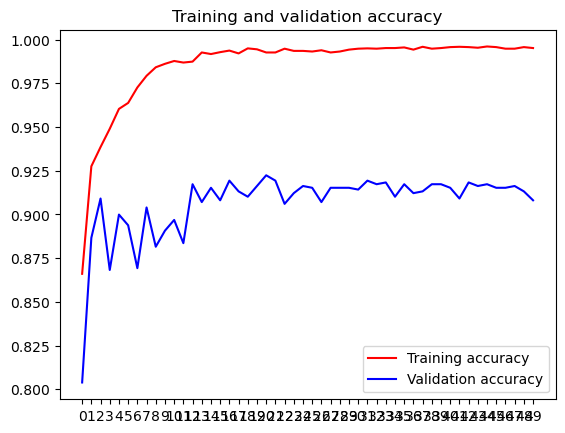

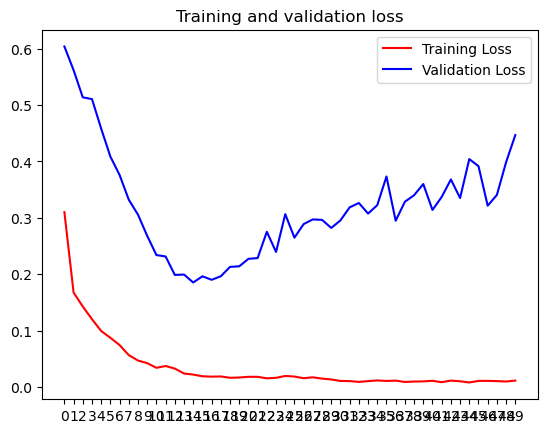

In [221]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = history.epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [222]:
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of the validation loss curve is {slope:.5f}")

The slope of the validation loss curve is -0.00030


<a name="3.8"></a>
#### 3.8 Testing model

In [223]:
test_df = pd.read_csv('data/test.csv', delimiter=',', quotechar='"')
test_cleaned = clean_data(test_df, False)
test_pad_trunc_seq = seq_pad_trunc(test_cleaned.TweetText, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [224]:
predections = model.predict(test_pad_trunc_seq)
predections

82/82 [==============================] - 9s 93ms/step


array([[4.4413450e-01],
       [6.5898307e-02],
       [1.0000000e+00],
       ...,
       [5.0637100e-06],
       [9.9998569e-01],
       [4.7297433e-02]], dtype=float32)

In [225]:
submissions = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label' : np.where(predections.reshape(-1) < 0.5, 'Sports', 'Politics')})
submissions

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Politics
2607,297956846046703616,Sports
2608,304265049537658880,Politics


In [226]:
submissions.to_csv('./submissions/submission.csv', index=False)

<a name="4"></a>
#### 4. Model comparison

In [313]:
tfidf = ('TfidfTransformer', TfidfVectorizer())
models = []
models.append(('MultinomialNB', Pipeline([tfidf, ('MultinomialNB', MultinomialNB())])))
models.append(('LogisticRegression', Pipeline([tfidf, ('LogisticRegression', LogisticRegression())])))
models.append(('SVM', Pipeline([tfidf, ('SVM', SVC())])))
models.append(('XGBoost', Pipeline([tfidf, ('XGBoost', XGBClassifier())])))

In [296]:
cleaned_X = clean_data(X, True)

In [314]:
splits = 16
score = 'accuracy'
models_score =[]
for i in models:
    kfold = KFold(n_splits=splits)
    results = cross_val_score(i[1], cleaned_X['TweetText'], y, cv=kfold, scoring=score)
    models_score.append({i[0] : '{} +/- {}'.format(results.mean(), results.std())})
models_score

[{'MultinomialNB': '0.9236710808401984 +/- 0.012273127695233255'},
 {'LogisticRegression': '0.9123356729055259 +/- 0.012464956583737837'},
 {'SVM': '0.9213774268921329 +/- 0.013590251310843142'},
 {'XGBoost': '0.8608327160716867 +/- 0.018218867315324815'}]

In [316]:
selected_model = models[0][1]

In [323]:
parameters = {
    'TfidfTransformer__use_idf': (True, False),
    'MultinomialNB__alpha': (2, 1, 1e-1, 1e-2, 1e-3),
}

In [329]:
gs_clf = GridSearchCV(selected_model, parameters, cv=16, n_jobs=-1)

In [330]:
gs_clf.fit(cleaned_X['TweetText'], y)

GridSearchCV(cv=16,
             estimator=Pipeline(steps=[('TfidfTransformer', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'MultinomialNB__alpha': (2, 1, 0.1, 0.01, 0.001),
                         'TfidfTransformer__use_idf': (True, False)})

In [335]:
gs_clf.best_params_

{'MultinomialNB__alpha': 0.1, 'TfidfTransformer__use_idf': False}

In [331]:
gs_clf.best_score_

0.927196623428241

In [332]:
best_selected_model = gs_clf.best_estimator_

In [333]:
cleaned_test = clean_data(test_df, True)['TweetText']
predections_mnb = best_selected_model.predict(cleaned_test)
submissions_mnb = pd.DataFrame({'TweetId': test_df['TweetId'], 'Label' : np.where(predections_mnb.reshape(-1) < 0.5, 'Sports', 'Politics')})
submissions_mnb

,TweetId,Label
0,306486520121012224,Sports
1,286353402605228032,Sports
2,289531046037438464,Politics
3,306451661403062273,Politics
4,297941800658812928,Sports
...,...,...
2605,282023761044189184,Sports
2606,303879735006601216,Sports
2607,297956846046703616,Sports
2608,304265049537658880,Politics


In [334]:
submissions_mnb.to_csv('./submissions/submission_mnb.csv', index=False)